In [10]:
from collections import Counter
import warnings

import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import label_binarize

from era_data import TabletPeriodDataset

warnings.filterwarnings(
    action='ignore', 
    message='is_sparse is deprecated and will be removed in a future version. Check `isinstance\(dtype, pd.SparseDtype\)` instead.',
    category=FutureWarning, 
    module='xgboost.*'
)

warnings.filterwarnings(
    action='ignore', 
    category=FutureWarning, 
    module='xgboost.*'  
)

# Loading Dataset - Extracted DinoV2 Vectors

In [3]:
df_features_train = pd.read_csv('output/dino_v2_train_set_vectors_greyscale_April20.csv', 
                                names=[f'X{i}' for i in range(384)] + ['Period'], 
                                header=0)
df_features_test = pd.read_csv('output/dino_v2_test_set_vectors_greyscale_April20.csv', 
                               names=[f'X{i}' for i in range(384)] + ['Period'], 
                               header=0)

# Preparing Data for Model

In [4]:
X_train_period = df_features_train.drop('Period', axis=1)
y_train_period = df_features_train["Period"]

X_train_period, X_val_period, y_train_period, y_val_period = train_test_split(X_train_period, y_train_period, test_size=0.111111111, random_state=0)

X_test_period = df_features_test.drop('Period', axis=1)
y_test_period = df_features_test["Period"]

In [5]:
len(y_train_period), len(y_val_period), len(y_test_period)

(75948, 9494, 9494)

In [6]:
D_train_period = xgb.DMatrix(X_train_period, label=y_train_period)
D_val_period = xgb.DMatrix(X_val_period, label=y_val_period)
D_test_period = xgb.DMatrix(X_test_period, label=y_test_period)

In [7]:
num_classes = len(TabletPeriodDataset.PERIOD_INDICES)
num_classes

22

# Clasification Model and Predictions

In [68]:
best_params = {'eta': 0.1, 'max_depth': 20, 'subsample': 0.9, 'objective': 'multi:softprob', 'num_class': 22, 'colsample_bytree': 0.9, 'nthread': 10}

In [69]:
bst = xgb.train(best_params, D_train_period, num_boost_round=50)
        
preds = bst.predict(D_val_period)
preds_labels = np.argmax(preds, axis=1)

In [70]:
preds_test = bst.predict(D_test_period)
preds_labels_test = np.argmax(preds_test, axis=1)

# Prediction analysis

In [71]:
EARLY_BRONZE = {
    'Old Akkadian', 'Ur III',
    'ED IIIb', 'Uruk III',
    'Proto-Elamite', 'Lagash II',
    'Ebla', 'ED IIIa', 'ED I-II',
    'Uruk IV', 'Linear Elamite',
    'Harappan'
    
}
MID_LATE_BRONZE = {
    'Early Old Babylonian',
    'Old Babylonian', 'Old Assyrian',
    'Middle Babylonian', 'Middle Assyrian',
    'Middle Elamite', 'Hittite'
}
IRON = {
    'Neo-Babylonian', 'Neo-Assyrian',
    'Achaemenid', 'Hellenistic',
    'Neo-Elamite'
}
ERA_MAP = {
    **{K: 'EB' for K in EARLY_BRONZE},
    **{K: 'MLB' for K in MID_LATE_BRONZE},
    **{K: 'I' for K in IRON},
}

In [72]:
def explain(period):
    return f'{period} ({ERA_MAP.get(period, "?")})'
explain('Neo-Babylonian')

'Neo-Babylonian (I)'

In [73]:
idx2period = {v: k for k, v in TabletPeriodDataset.PERIOD_INDICES.items()}
idx2period[0] = 'other'

In [74]:
idx2period[0], idx2period[5]

('other', 'Neo-Babylonian')

In [75]:
list(set(y_test_period) | set(preds_labels_test))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

In [76]:
indices = list(set(y_test_period) | set(preds_labels_test))
print(len(indices))
print(indices)
PERIOD_LABELS = [explain(idx2period[i]) for i in indices]
print(PERIOD_LABELS)

22
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
['other (?)', 'Ur III (EB)', 'Neo-Assyrian (I)', 'Old Babylonian (MLB)', 'Middle Babylonian (MLB)', 'Neo-Babylonian (I)', 'Old Akkadian (EB)', 'Achaemenid (I)', 'Early Old Babylonian (MLB)', 'ED IIIb (EB)', 'Middle Assyrian (MLB)', 'Old Assyrian (MLB)', 'Uruk III (EB)', 'Proto-Elamite (EB)', 'Lagash II (EB)', 'Ebla (EB)', 'ED IIIa (EB)', 'Hellenistic (I)', 'ED I-II (EB)', 'Middle Elamite (MLB)', 'Middle Hittite (MLB)', 'Uruk IV (EB)']


In [77]:
print(classification_report(y_test_period, preds_labels_test, target_names=PERIOD_LABELS))

                            precision    recall  f1-score   support

                 other (?)       0.00      0.00      0.00        60
               Ur III (EB)       0.02      0.00      0.00      2782
          Neo-Assyrian (I)       0.50      0.03      0.05      2326
      Old Babylonian (MLB)       0.18      0.20      0.19      1634
   Middle Babylonian (MLB)       0.00      0.00      0.00       635
        Neo-Babylonian (I)       0.00      0.00      0.00       504
         Old Akkadian (EB)       0.00      0.00      0.00       295
            Achaemenid (I)       0.02      0.80      0.04       183
Early Old Babylonian (MLB)       0.00      0.00      0.00       217
              ED IIIb (EB)       0.00      0.00      0.00       159
     Middle Assyrian (MLB)       0.00      0.00      0.00       148
        Old Assyrian (MLB)       0.00      0.00      0.00       157
             Uruk III (EB)       0.00      0.00      0.00        83
        Proto-Elamite (EB)       0.00      0.00

/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [78]:
# let's just use classes with support >=40, everything else goes to 0: other
COMMON_LABELS = list({k for k, v in Counter(y_test_period).items() if v >= 40})
print(f'Common labels: ({len(COMMON_LABELS)})')
[(i, explain(idx2period[i])) for i in COMMON_LABELS]

Common labels: (17)


[(0, 'other (?)'),
 (1, 'Ur III (EB)'),
 (2, 'Neo-Assyrian (I)'),
 (3, 'Old Babylonian (MLB)'),
 (4, 'Middle Babylonian (MLB)'),
 (5, 'Neo-Babylonian (I)'),
 (6, 'Old Akkadian (EB)'),
 (7, 'Achaemenid (I)'),
 (8, 'Early Old Babylonian (MLB)'),
 (9, 'ED IIIb (EB)'),
 (10, 'Middle Assyrian (MLB)'),
 (11, 'Old Assyrian (MLB)'),
 (12, 'Uruk III (EB)'),
 (13, 'Proto-Elamite (EB)'),
 (14, 'Lagash II (EB)'),
 (15, 'Ebla (EB)'),
 (16, 'ED IIIa (EB)')]

In [79]:
y_true_c = y_test_period.copy()
y_true_c[~np.isin(y_test_period, COMMON_LABELS)] = 0
print((~np.isin(y_test_period, COMMON_LABELS)).mean(), 'changed to "other"')

0.010111649462818622 changed to "other"


In [80]:
y_pred_c = preds_labels_test.copy()
y_pred_c[~np.isin(preds_labels_test, COMMON_LABELS)] = 0
print((~np.isin(preds_labels_test, COMMON_LABELS)).mean(), 'changed to "other"')

0.0 changed to "other"


In [81]:
indices_c = list(set(y_true_c))
print(len(indices_c))
print(indices_c)
PERIOD_LABELS_C = [explain(idx2period[i]) for i in indices_c]
print(PERIOD_LABELS_C)

17
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
['other (?)', 'Ur III (EB)', 'Neo-Assyrian (I)', 'Old Babylonian (MLB)', 'Middle Babylonian (MLB)', 'Neo-Babylonian (I)', 'Old Akkadian (EB)', 'Achaemenid (I)', 'Early Old Babylonian (MLB)', 'ED IIIb (EB)', 'Middle Assyrian (MLB)', 'Old Assyrian (MLB)', 'Uruk III (EB)', 'Proto-Elamite (EB)', 'Lagash II (EB)', 'Ebla (EB)', 'ED IIIa (EB)']


In [82]:
set(y_true_c)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}

In [83]:
print(classification_report(y_true_c, y_pred_c, target_names=PERIOD_LABELS_C))

                            precision    recall  f1-score   support

                 other (?)       0.00      0.00      0.00       156
               Ur III (EB)       0.02      0.00      0.00      2782
          Neo-Assyrian (I)       0.50      0.03      0.05      2326
      Old Babylonian (MLB)       0.18      0.20      0.19      1634
   Middle Babylonian (MLB)       0.00      0.00      0.00       635
        Neo-Babylonian (I)       0.00      0.00      0.00       504
         Old Akkadian (EB)       0.00      0.00      0.00       295
            Achaemenid (I)       0.02      0.80      0.04       183
Early Old Babylonian (MLB)       0.00      0.00      0.00       217
              ED IIIb (EB)       0.00      0.00      0.00       159
     Middle Assyrian (MLB)       0.00      0.00      0.00       148
        Old Assyrian (MLB)       0.00      0.00      0.00       157
             Uruk III (EB)       0.00      0.00      0.00        83
        Proto-Elamite (EB)       0.00      0.00

/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [84]:
Y = label_binarize(y_test_period, classes=np.unique(y_test_period))
n_classes = Y.shape[1]

auc_scores = []
for i in range(n_classes):
    auc = roc_auc_score(Y[:, i], preds_test[:, i])
    auc_scores.append(auc)

macro_ovr_auc = np.mean(auc_scores)
print(f"Macro-OvR-AUC: {macro_ovr_auc}")

Macro-OvR-AUC: 0.540172073466883


# TSNE over the extracted vectors

In [49]:
F = TSNE(n_components=2, init='pca').fit_transform(X_train_period)

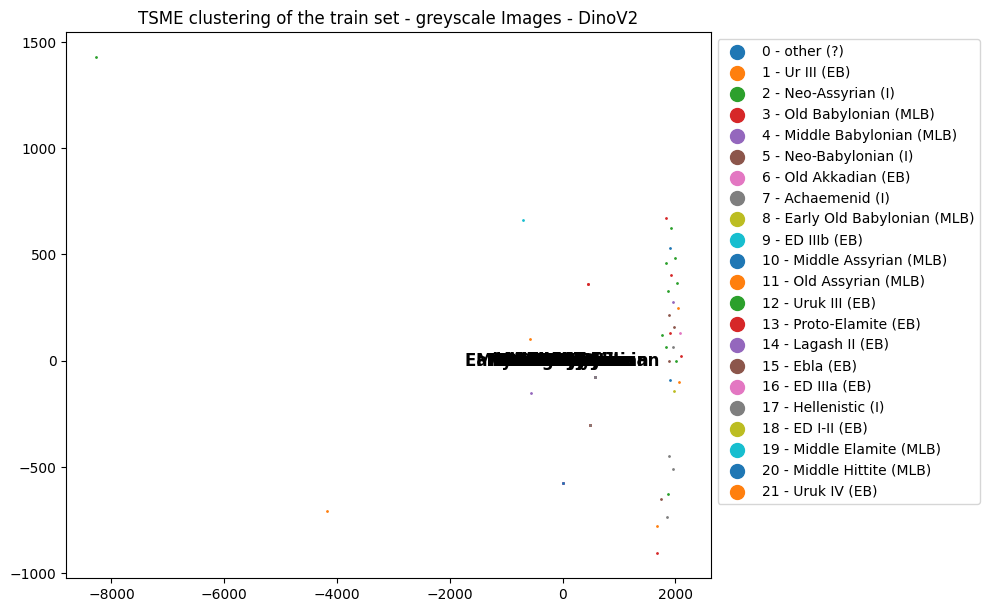

In [50]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

for period in set(y_train_period):
    period_data = F[y_train_period == period]
    
    # Scatter plot for the period.
    plt.scatter(period_data[:, 0], period_data[:, 1], label=f'{period} - {explain(idx2period[period])}', s=1)
    
    centroid = np.mean(period_data, axis=0)
    
    ax.text(centroid[0], centroid[1], f'{idx2period[period]}', horizontalalignment='center', verticalalignment='center', fontsize=12, weight='bold')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), markerscale=10)
plt.tight_layout()
plt.title('TSME clustering of the train set - greyscale Images - DinoV2')
scatter_pdf_path = 'output/plots/TSNEclusteringGreyscale.pdf'
plt.savefig(scatter_pdf_path, format='pdf')

#plt.show()